Text(0.5, 1.0, 'Generated 2D Spectrum')

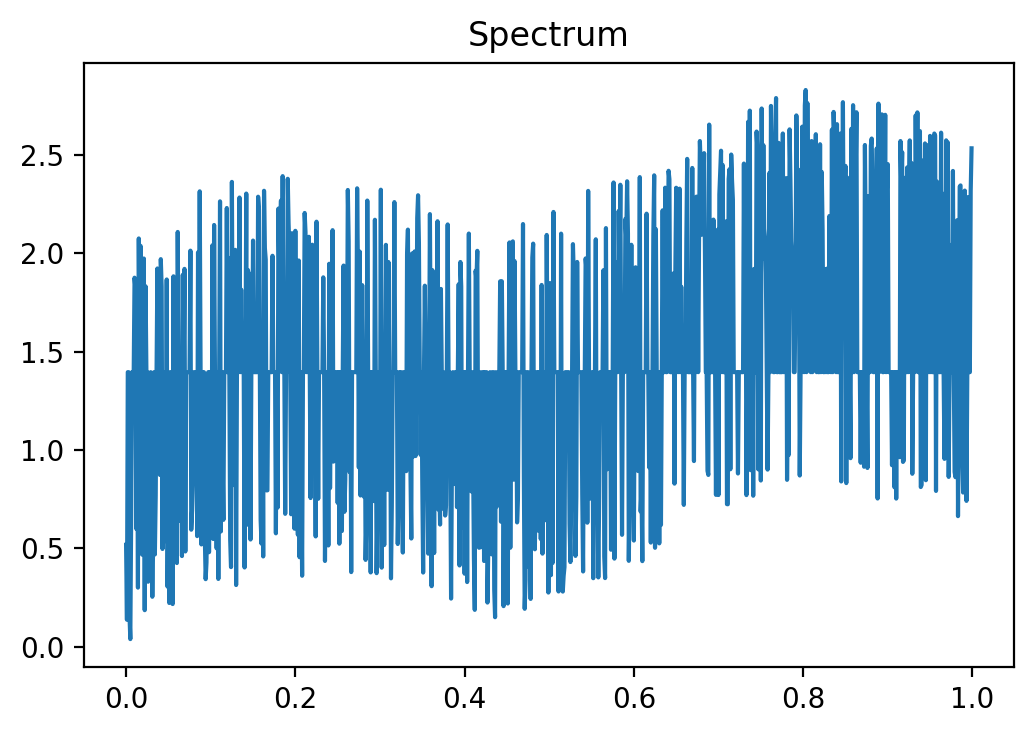

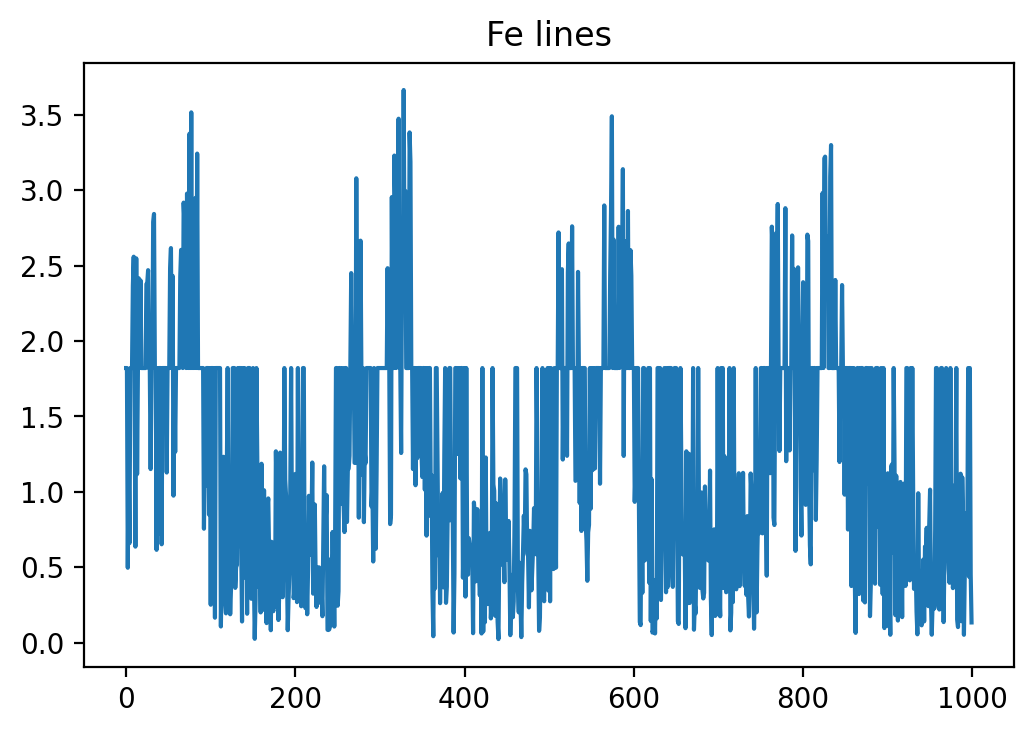

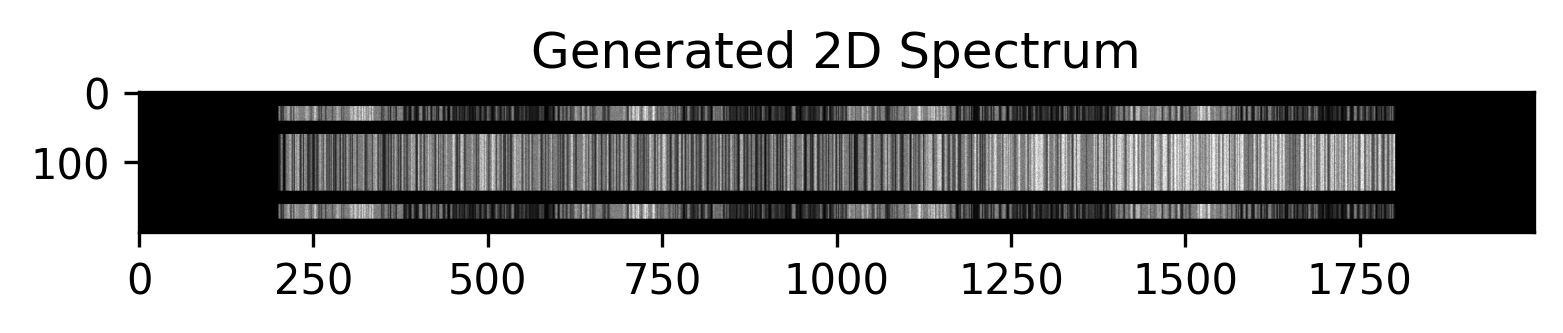

In [81]:
!export XUVTOP=/home/facundoq/.soft/CHIANTI_10.0.1_database/
import numpy as np

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from skimage.draw import line_aa
from astropy.io import fits
import ChiantiPy.core as ch

from skimage.util import random_noise

class Spectrum:
    def __init__(self,values:np.ndarray,values_position:np.ndarray,
                 lines:np.ndarray,lines_position1,lines_position2):
        # positions = [left, top, right, bottom]
        assert len(values_position)==4
        assert len(lines_position1)==4
        assert len(lines_position2)==4
        
        self.values=values
        self.values_position = values_position
        
        self.lines = lines
        self.lines_position1= lines_position1
        self.lines_position2 = lines_position2
        
    
    def get_interpolator(self,y):
        n = y.shape[0]
        spectrum_x = np.linspace(0,1,n,endpoint=True)
        interpolator = interp1d(spectrum_x,y)
        return interpolator
    
    def plot_spectrum(self,image,y,positions):
        h,w = image.shape
        interpolator = self.get_interpolator(y)
        
        # Calculate positions of spectrum
        positions = np.array([w,h,w,h]) * positions
        start_c,start_r,end_c,end_r = positions.astype(int)
        
        c,r=end_c-start_c,end_r-start_r
        for i in range(c):
            spectrum_x=i/c
            spectrum_y = interpolator(spectrum_x)
            rr, cc, val = line_aa(start_r,i+start_c,end_r, i+1+start_c)
            image[rr, cc] = spectrum_y
            
    def preprocess(self,y,normalize:bool):
        if normalize:
            y = y-y.min()
            y/=y.max()
        return y
    def plot(self,h,w,add_noise=True,normalize=True):
        image = np.zeros((h,w), dtype=np.float64)
        lines = self.preprocess(self.lines,normalize)
        self.plot_spectrum(image,self.preprocess(self.values,normalize),self.values_position)
        self.plot_spectrum(image,lines,self.lines_position1)
        self.plot_spectrum(image,lines,self.lines_position2)
        if add_noise:
#             image = random_noise(image, mode='s&p', amount=0.005, clip=True)
            image = random_noise(image, mode='speckle', clip=True)

        return image
    
def generate_sin(n_values,speed):
    x = np.array(range(n_values))*speed
    noise = np.random.rand(n_values)*2
    noise2 = np.random.rand(n_values)*0.1
    values = np.sin(x)*0.2+np.sin(x/10)*0.5+np.sin(4*x/n_values*2*np.pi)+noise
    values = np.abs(values)+noise2
    mi,ma = values.min(),values.max()
    c = ma-mi
    indices = np.logical_and(values>c*0.35,values<c*0.65)
    values[indices] = c/2
    return x, values
    
def chianti_ion(x,ion='fe_2'):
    
    element = ch.ion('fe_10', 2.e+6, 1.e+9)
    element.spectrum(x)#,1.e+27
    
    return x, element.Spectrum['intensity'] 
    
def guide_lines(n_values,n_lines=100):
    lines = np.random.randint(0,n_lines,n_values)
    lines = np.sort(lines)
    return lines

n_values = 1000
left,right=0.1,0.9
y_position = np.array([left,0.3,right,0.7]) #LTRB
lines_position1 = np.array([left,0.1,right,0.2]) 
lines_position2 = np.array([left,0.8,right,0.9]) 
x,y = generate_sin(n_values,speed=0.01)
line_x,line_y = generate_sin(n_values,speed=1)

# line_x= np.arange(150,500,5)
# line_x,line_y = chianti_ion(line_x)

lines = guide_lines(n_values,n_lines=100)

x = np.arange(len(y))/len(y)


plt.figure(dpi=200)
plt.plot(x,y)
plt.title("Spectrum")

plt.figure(dpi=200)
plt.plot(line_x,line_y)
plt.title("Fe lines")

s = Spectrum(y,y_position,line_y,lines_position1,lines_position2)
s_image = s.plot(200,2000)

plt.figure(dpi=300)
plt.imshow(s_image,cmap="gray",)
plt.title("Generated 2D Spectrum")